In [11]:
import sys
import os

# Add the 'src' directory to the Python path
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

In [13]:
from NeuralNetwork import Neural_Network
from GD_class import GradientDescent
from cost_functions import grad_mse
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.model_selection import KFold
from tqdm import tqdm 

import jax

seed = 1342
np.random.seed(seed)
jax.random.PRNGKey(seed)

def plot_heatmap(values, x_ticks, y_ticks, x_label, y_label, title):
    fig, ax = plt.subplots(figsize = (6, 5))
    heatmap = sns.heatmap(values, annot=True, ax=ax, cmap="viridis")
    heatmap.set_xticklabels(x_ticks)
    heatmap.set_yticklabels(y_ticks)
    ax.set_title(title)
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)
    plt.show()
    

# Testing NN on simple function

In [3]:


n = 1000
true_beta = [2, 0.5, 3.2]

x = jnp.linspace(0, 1, n)

target = jnp.sum(jnp.asarray([x ** p * b for p, b in enumerate(true_beta)]),
                 axis=0) + 0.5 * np.random.normal(size=len(x))

x = x.reshape(len(x), 1)
target = target.reshape(len(target), 1)

# Setup for neural network:
n_hidden_layers = 1
n_hidden_nodes = 2
n_outputs = 1
n_features = x.shape[1]

# Splitting the data into training and test set:
test_size = 0.2
x_train, x_test, target_train, target_test = train_test_split(x, target, test_size=test_size)

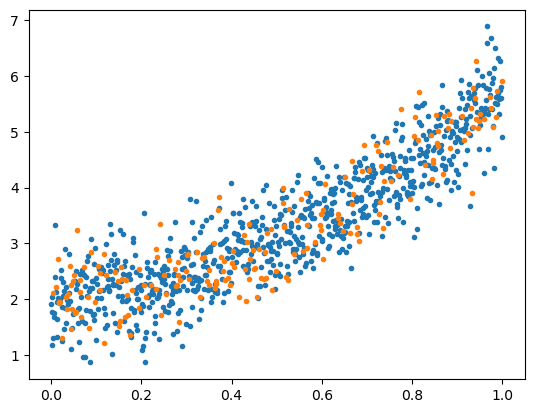

In [4]:
plt.figure()
plt.plot(x_train, target_train, ".")
plt.plot(x_test, target_test, ".")
plt.show()

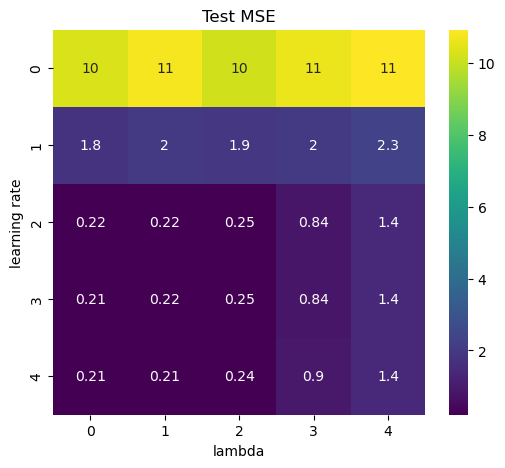

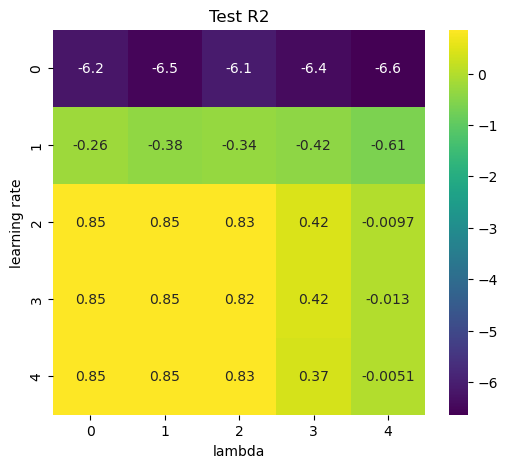

In [6]:
learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-4, 0, 5)

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

for i, lr in enumerate(learning_rates):
    for j, lmbd in enumerate(lmbd_vals):
        
        ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                              grad_cost_function=grad_mse,
                              learning_rate=lr, 
                              lmbd=lmbd, 
                              activation_function_hidden='sigmoid',
                              activation_function_output='Linear',
                              optimizer=None,
                              classification_problem=False)
        
        ffnn.train(x_train, target_train, num_iter=1000)
        pred_train = ffnn.predict(x_train)
        pred_test = ffnn.predict(x_test)

        mse[i][j] = mean_squared_error(target_test, pred_test)
        r2[i][j] = r2_score(target_test, pred_test)

        
fig, ax = plt.subplots(figsize = (6, 5))
sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test MSE")
ax.set_ylabel("learning rate")
ax.set_xlabel("lambda")
plt.show()

fig, ax = plt.subplots(figsize = (6, 5))
sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test R2")
ax.set_ylabel("learning rate")
ax.set_xlabel("lambda")
plt.show()

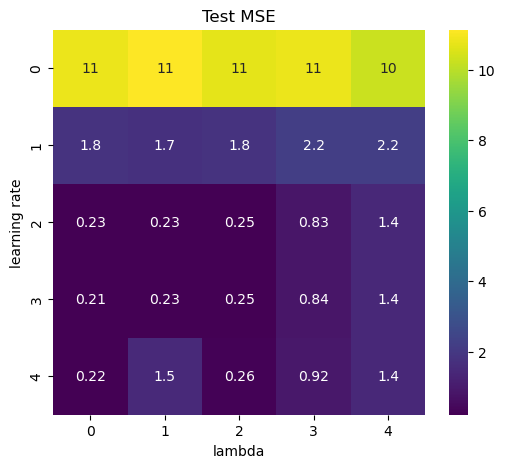

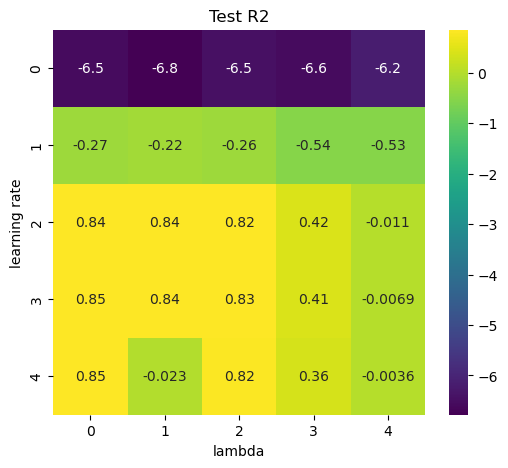

In [7]:
# With minibatches:
learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-4, 0, 5)

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

for i, lr in enumerate(learning_rates):
    for j, lmbd in enumerate(lmbd_vals):
        
        ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                              grad_cost_function=grad_mse,
                              learning_rate=lr, 
                              lmbd=lmbd, 
                              activation_function_hidden='sigmoid',
                              activation_function_output='Linear',
                              optimizer=None,
                              classification_problem=False)
        
        ffnn.train(x_train, target_train, num_iter=100, n_minibatches=10)
        pred_train = ffnn.predict(x_train)
        pred_test = ffnn.predict(x_test)

        mse[i][j] = mean_squared_error(target_test, pred_test)
        r2[i][j] = r2_score(target_test, pred_test)

        
fig, ax = plt.subplots(figsize = (6, 5))
sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test MSE")
ax.set_ylabel("learning rate")
ax.set_xlabel("lambda")
plt.show()

fig, ax = plt.subplots(figsize = (6, 5))
sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test R2")
ax.set_ylabel("learning rate")
ax.set_xlabel("lambda")
plt.show()

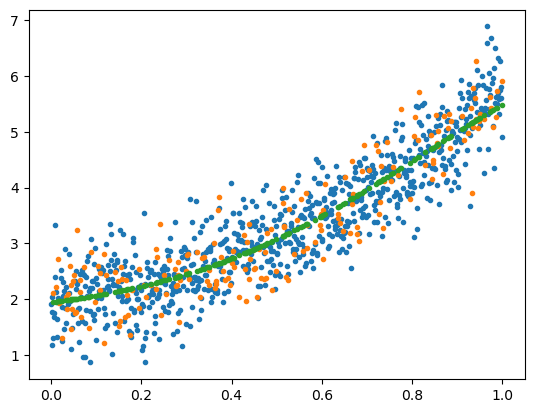

In [8]:
ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                      grad_cost_function=grad_mse,
                      learning_rate=1e-02, 
                      lmbd=0.0001, 
                      activation_function_hidden='sigmoid',
                      activation_function_output='Linear',
                      optimizer=None,
                      classification_problem=False)

ffnn.train(x_train, target_train, num_iter=1000)
pred_test = ffnn.predict(x_test)

plt.figure()
plt.plot(x_train, target_train, ".")
plt.plot(x_test, target_test, ".")
plt.plot(x_test, pred_test, ".")
plt.show()

# Using NN on Franke function

In [27]:
def FrankeFunction(x,y):
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [28]:
N = 1000
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)

# Franke function with added noise:
z = FrankeFunction(x, y) + np.random.normal(0, 0.1, x.shape)
target = jnp.array(z).reshape(len(z), 1)

# Making the design matrix:
X = jnp.stack((x, y), axis=-1)

# Splitting the data into training and test set:
test_size = 0.2
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=test_size)
X_train.shape

(800, 2)

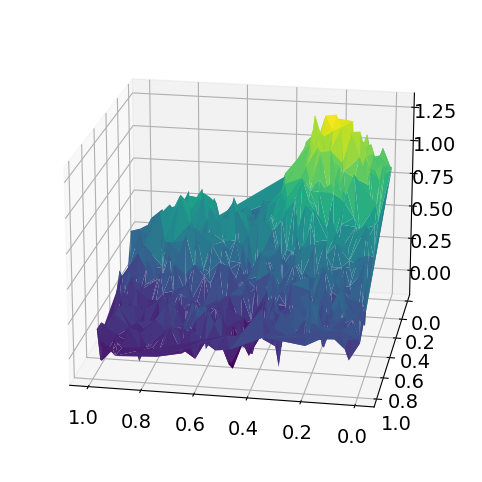

In [ ]:
        # Show the terrain
        plt.figure()
        #plt.title('Terrain over Norway')
        plt.imshow(terrain, cmap='gray')
        #plt.imshow(terrain[:N, :N], cmap='gray')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.savefig("Showing_terrain_{data_used}")
        plt.show()

# Tuning the number of minibatches and epochs

In [86]:
n_hidden_layers = 2
n_hidden_nodes = 6

n_outputs = 1
n_features = X.shape[1] 

activation_hidden = "sigmoid"

learning_rate = 0.01
lmbd = 0.0001

n_epochs_list = [50, 100, 150]
n_minibatches_list = [8, 16, 32]

mse = np.zeros((len(n_epochs_list), len(n_minibatches_list)))
r2 = np.zeros((len(n_epochs_list), len(n_minibatches_list)))

kfold = KFold(n_splits=5, shuffle=True)

for k, n_epochs in enumerate(n_epochs_list):

    for i, n_minibatches in tqdm(enumerate(n_minibatches_list)):

        mse_crossval = []
        r2_crossval = []

        for train_index, val_index in kfold.split(X_train):
            
            # Splitting the data into training and validation set for cross-validation
            X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
            target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_mse,
                                  learning_rate=learning_rate, 
                                  lmbd=lmbd, 
                                  activation_function_hidden=activation_hidden,
                                  activation_function_output='Linear',
                                  optimizer=None,
                                  classification_problem=False)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, 
                       n_minibatches=n_minibatches)
            pred_val = ffnn.predict(X_val_cv)

            mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
            r2_crossval.append(r2_score(target_val_cv, pred_val))

        mse[k][i] = np.mean(mse_crossval)
        r2[k][i] = np.mean(r2_crossval)


3it [00:37, 12.63s/it]
3it [01:12, 24.22s/it]
3it [01:50, 36.80s/it]


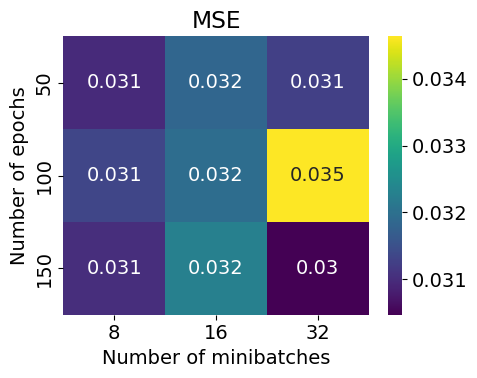

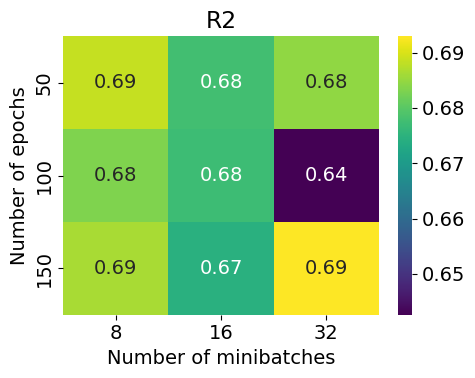

In [18]:
fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_minibatches_list)
heatmap.set_yticklabels(n_epochs_list)
ax.set_title("MSE")
ax.set_ylabel("Number of epochs")
ax.set_xlabel("Number of minibatches")
plt.tight_layout()
plt.savefig(r"Figures\Task_b\Franke_tune_epochs_and_minibatches_MSE_2.png")
plt.show()

fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_minibatches_list)
heatmap.set_yticklabels(n_epochs_list)
ax.set_title("R2")
ax.set_ylabel("Number of epochs")
ax.set_xlabel("Number of minibatches")
plt.tight_layout()
plt.savefig(r"Figures\Task_b\Franke_tune_epochs_and_minibatches_R2_2.png")
plt.show()

150 epochs med 32 minibatcher gir lavest MSE score og høyest R2 score. Bruker disse parametrene videre.

# Tuning number of hidden layers and hidden nodes

In [88]:
n_hidden_layers_list = [2, 3, 4]
n_hidden_nodes_list = [2, 6, 10]

n_outputs = 1
n_features = X.shape[1] 

activation_hidden = "sigmoid"

learning_rate = 0.01
lmbd = 0.0001

n_epochs = 150
n_minibatches = 32

mse = np.zeros((len(n_hidden_layers_list), len(n_hidden_nodes_list)))
r2 = np.zeros((len(n_hidden_layers_list), len(n_hidden_nodes_list)))

kfold = KFold(n_splits=5, shuffle=True)

for k, n_hidden_layer in tqdm(enumerate(n_hidden_layers_list)):

    for i, n_hidden_nodes in enumerate(n_hidden_nodes_list):

        mse_crossval = []
        r2_crossval = []

        for train_index, val_index in kfold.split(X_train):
            
            # Splitting the data into training and validation set for cross-validation
            X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
            target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_mse,
                                  learning_rate=learning_rate, 
                                  lmbd=lmbd, 
                                  activation_function_hidden=activation_hidden,
                                  activation_function_output='Linear',
                                  optimizer=None,
                                  classification_problem=False)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, 
                       n_minibatches=n_minibatches) 
            pred_val = ffnn.predict(X_val_cv)

            mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
            r2_crossval.append(r2_score(target_val_cv, pred_val))

        mse[k][i] = np.mean(mse_crossval)
        r2[k][i] = np.mean(r2_crossval)


3it [09:31, 190.47s/it]


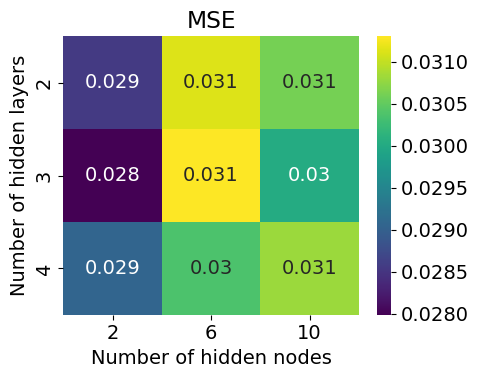

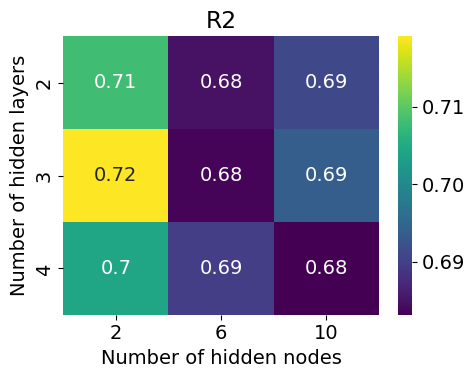

In [20]:
fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_hidden_nodes_list)
heatmap.set_yticklabels(n_hidden_layers_list)
ax.set_title("MSE")
ax.set_ylabel("Number of hidden layers")
ax.set_xlabel("Number of hidden nodes")
plt.tight_layout()
plt.savefig(r"Figures\Task_b\Franke_tune_hidden_layers_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_hidden_nodes_list)
heatmap.set_yticklabels(n_hidden_layers_list)
ax.set_title("R2")
ax.set_ylabel("Number of hidden layers")
ax.set_xlabel("Number of hidden nodes")
plt.tight_layout()
plt.savefig(r"Figures\Task_b\Franke_tune_hidden_layers_R2.png")
plt.show()

Best: 3 hidden layers and 2 hidden nodes

# Tuning lambda and learning rate

In [94]:
n_hidden_layers = 3
n_hidden_nodes = 2

n_outputs = 1
n_features = X.shape[1] 

activation_hidden = "sigmoid"

learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-5, -2, 4)
lmbd_vals = jnp.insert(lmbd_vals, 0, 0.0)

n_epochs = 150
n_minibatches = 32

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

kfold = KFold(n_splits=5, shuffle=True)

for i, learning_rate in tqdm(enumerate(learning_rates)):

    for j, lmbd in enumerate(lmbd_vals):

        mse_crossval = []
        r2_crossval = []

        for train_index, val_index in kfold.split(X_train):

            X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
            target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_mse,
                                  learning_rate=learning_rate, 
                                  lmbd=lmbd, 
                                  activation_function_hidden=activation_hidden,
                                  activation_function_output='Linear',
                                  optimizer=None,
                                  classification_problem=False)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, 
                       n_minibatches=n_minibatches)
            pred_val = ffnn.predict(X_val_cv)

            mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
            r2_crossval.append(r2_score(target_val_cv, pred_val))

        mse[i][j] = np.mean(mse_crossval)
        r2[i][j] = np.mean(r2_crossval)

            

5it [31:15, 375.10s/it]


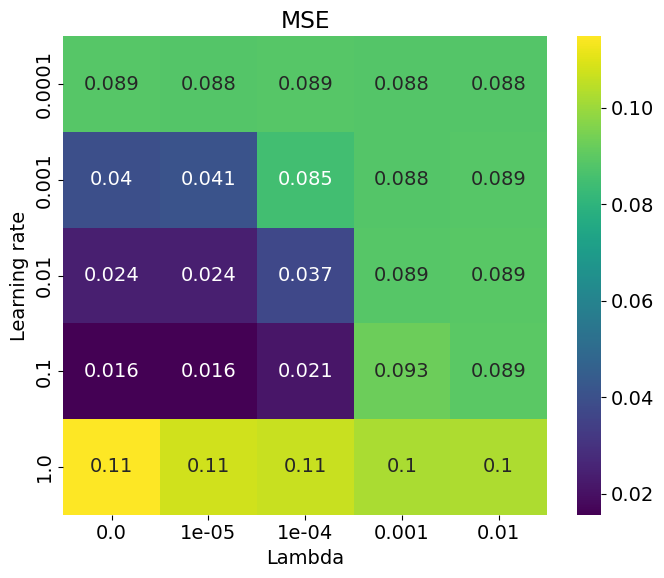

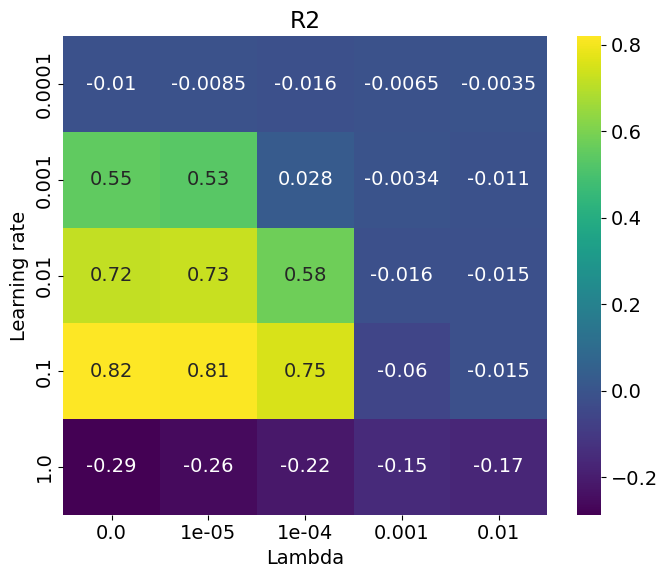

In [95]:
fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("MSE")
ax.set_ylabel('Learning rate')
ax.set_xlabel('Lambda')
plt.tight_layout()
plt.savefig(r"Figures\Task_b\Franke_tune_lambda_and_lr_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("R2")
ax.set_ylabel('Learning rate')
ax.set_xlabel('Lambda')
plt.tight_layout()
plt.savefig(r"Figures\Task_b\Franke_tune_lambda_and_lr_R2.png")
plt.show()

## Final test of model

In [100]:
n_hidden_layers = 3
n_hidden_nodes = 2

n_outputs = 1
n_features = X.shape[1] 

activation_hidden = "sigmoid"

learning_rate = 0.1
lmbd = 0.0

n_epochs = 150
n_minibatches = 32

# Training the network again with all the training data and the tuned parameters
ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                      grad_cost_function=grad_mse,
                      learning_rate=learning_rate, lmbd=lmbd, 
                      activation_function_hidden=activation_hidden,
                      activation_function_output='Linear',
                      optimizer=None,
                      classification_problem=False)

ffnn.train(X_train, target_train, num_iter=n_epochs, n_minibatches=n_minibatches)
pred_test = ffnn.predict(X_test)

mse_test = mean_squared_error(target_test, pred_test)
r2_test = r2_score(target_test, pred_test)

print(f"MSE for test data: {mse_test}")
print(f"R2 for test data: {r2_test}")

MSE for test data: 0.012151574715971947
R2 for test data: 0.8852545287230728


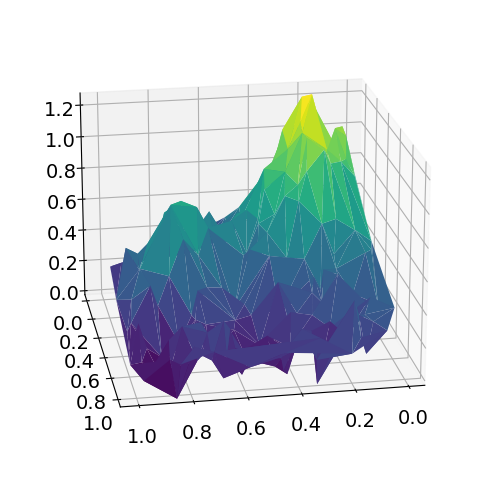

In [97]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_trisurf(X_test[:, 0], X_test[:, 1], np.squeeze(target_test), cmap='viridis')
ax.view_init(elev=20, azim=80)
ax.set_zlim(0, 1.25)
plt.savefig(r"Figures\Task_b\True_test_data_3Dplot.png")
plt.show()

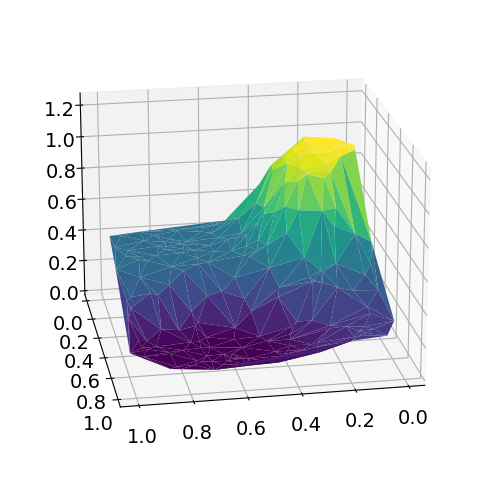

In [98]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_trisurf(X_test[:, 0], X_test[:, 1], np.squeeze(pred_test), cmap='viridis')
ax.view_init(elev=20, azim=80)
ax.set_zlim(0, 1.25)
plt.savefig(r"Figures\Task_b\Predicted_test_data_3Dplot.png")
plt.show()

## Testing different activation functions

### Rectified Linear Unit (ReLU)

In [76]:
n_hidden_layers = 3
n_hidden_nodes = 2

n_outputs = 1
n_features = X_train.shape[1] 

activation_hidden = "ReLU"

n_epochs = 150
n_minibatches = 32

learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-5, -2, 4)
lmbd_vals = jnp.insert(lmbd_vals, 0, 0.0)

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

for i, lr in tqdm(enumerate(learning_rates)):

        for j, lmbd in enumerate(lmbd_vals):

            mse_crossval = []
            r2_crossval = []

            for train_index, val_index in kfold.split(X_train):

                X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
                target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

                ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                      grad_cost_function=grad_mse,
                                      learning_rate=lr, 
                                      lmbd=lmbd, 
                                      activation_function_hidden=activation_hidden,
                                      activation_function_output='Linear',
                                      optimizer=None,
                                      classification_problem=False)

                ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, n_minibatches=n_minibatches)
                pred_val = ffnn.predict(X_val_cv)

                mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
                r2_crossval.append(r2_score(target_val_cv, pred_val))

            mse[i][j] = np.mean(mse_crossval)
            r2[i][j] = np.mean(r2_crossval)



5it [2:36:20, 1876.16s/it]


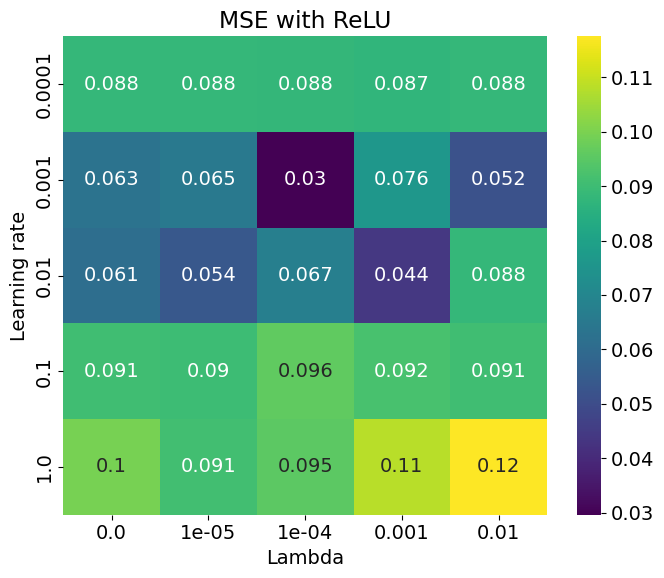

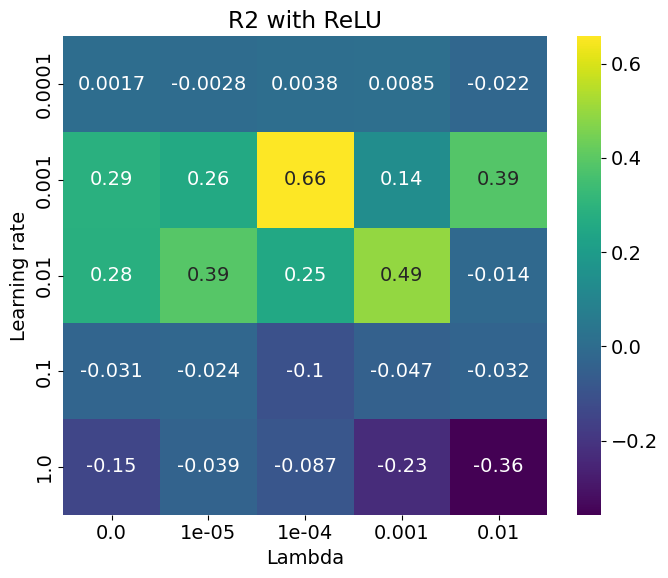

In [77]:
fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("MSE with ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\Task_c\Franke_testing_ReLU_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("R2 with ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\Task_c\Franke_testing_ReLU_R2.png")
plt.show()

In [80]:
n_hidden_layers = 3
n_hidden_nodes = 2

n_outputs = 1
n_features = X_train.shape[1] 

activation_hidden = "ReLU"

learning_rate = 0.001
lmbd = 1e-4

n_epochs = 150
n_minibatches = 32

# Training the network again with all the training data and the tuned parameters
ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                      grad_cost_function=grad_mse,
                      learning_rate=learning_rate, lmbd=lmbd, 
                      activation_function_hidden=activation_hidden,
                      activation_function_output='Linear',
                      optimizer=None,
                      classification_problem=False)

ffnn.train(X_train, target_train, num_iter=n_epochs, n_minibatches=n_minibatches)
pred_test = ffnn.predict(X_test)

mse_test = mean_squared_error(target_test, pred_test)
r2_test = r2_score(target_test, pred_test)

print(f"MSE for test data using ReLU: {mse_test}")
print(f"R2 for test data using ReLU: {r2_test}")

MSE for test data using ReLU: 0.03441489860415459
R2 for test data using ReLU: 0.6750253713744616


### Leaky ReLU

5it [31:36, 379.28s/it]


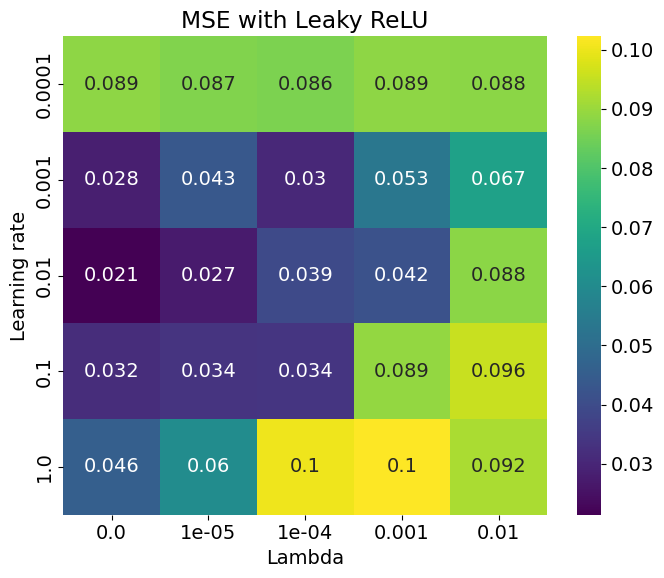

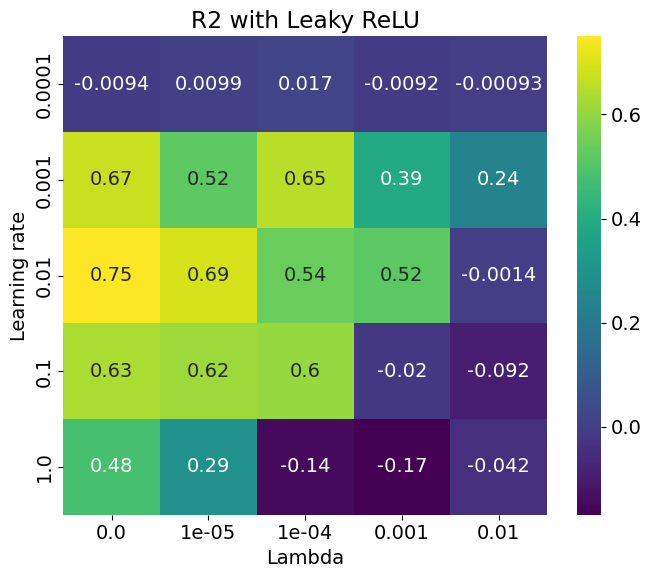

In [81]:
n_hidden_layers = 3
n_hidden_nodes = 2
n_outputs = 1
n_features = X.shape[1] 

activation_hidden = 'Leaky ReLU'

n_epochs = 150
n_minibatches = 32

learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-5, -2, 4)
lmbd_vals = jnp.insert(lmbd_vals, 0, 0.0)

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

for i, lr in tqdm(enumerate(learning_rates)):

        for j, lmbd in enumerate(lmbd_vals):

            mse_crossval = []
            r2_crossval = []

            for train_index, val_index in kfold.split(X_train):

                X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
                target_train_cv, target_val_cv = target_train[train_index], target_train[val_index]

                ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                      grad_cost_function=grad_mse,
                                      learning_rate=lr, 
                                      lmbd=lmbd, 
                                      activation_function_hidden=activation_hidden,
                                      activation_function_output='Linear',
                                      optimizer=None,
                                      classification_problem=False)

                ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, n_minibatches=n_minibatches)
                pred_val = ffnn.predict(X_val_cv)

                mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
                r2_crossval.append(r2_score(target_val_cv, pred_val))

            mse[i][j] = np.mean(mse_crossval)
            r2[i][j] = np.mean(r2_crossval)


fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("MSE with Leaky ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\Task_c\Franke_testing_LeakyReLU_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("R2 with Leaky ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\Task_c\Franke_testing_LeakyReLU_R2.png")
plt.show()

In [82]:
n_hidden_layers = 3
n_hidden_nodes = 2

n_outputs = 1
n_features = X.shape[1] 

activation_hidden = 'Leaky ReLU'

learning_rate = 0.01
lmbd = 0.0

n_epochs = 150
n_minibatches = 32

# Training the network again with all the training data and the tuned parameters
ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                      grad_cost_function=grad_mse,
                      learning_rate=learning_rate, lmbd=lmbd, 
                      activation_function_hidden=activation_hidden,
                      activation_function_output='Linear',
                      optimizer=None,
                      classification_problem=False)

ffnn.train(X_train, target_train, num_iter=n_epochs, n_minibatches=n_minibatches)
pred_test = ffnn.predict(X_test)

mse_test = mean_squared_error(target_test, pred_test)
r2_test = r2_score(target_test, pred_test)

print(f"MSE for test data using Leaky ReLU: {mse_test}")
print(f"R2 for test data using Leaky ReLU: {r2_test}")

MSE for test data using Leaky ReLU: 0.02685835212469101
R2 for test data using Leaky ReLU: 0.7463806676371962
